In [1]:
import os
import numpy as np
import efficientnet.tfkeras
from tensorflow.keras.models import load_model

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]=""

# Select Data

In [3]:
import pandas as pd
df0 = pd.read_csv (r'/home/yupaporn/codes/USAI/detail1_350_.csv')
df01 = df0[(df0['Path Crop']!='None' )&(df0['Path Crop']!='Nan')]
a = df01[df01['Case'].between(1, 10)]
dataframe = a[a['Abs Position']!='P8']
print(dataframe.shape)
print('Normal: ',dataframe[dataframe['Class']=='Normal'].shape)
print('Abnormal: ',dataframe[dataframe['Class']=='Abnormal'].shape)

(405, 8)
Normal:  (115, 8)
Abnormal:  (290, 8)


# load model

In [5]:
model_dir ='/media/tohn/SSD/unfreez_model/TrainB0_NA_UnBlock1/models/B0_R1.h5'
model = load_model(model_dir)
height = width = model.input_shape[1]

In [6]:
# validation
import pandas as pd
base_dir  = '/media/tohn/SSD/ImageForTrainTest/validation/'
dataframe = pd.read_csv( '/media/tohn/SSD/ImageForTrainTest/validation.csv')
validation_dir = os.path.join(base_dir, 'validation')

#Train
train_df = pd.read_csv( '/media/tohn/SSD/ImageForTrainTest/train.csv')
base_dir0 = '/media/tohn/SSD/ImageForTrainTest/'
os.chdir(base_dir0)
train_dir = os.path.join(base_dir0, 'train')

In [7]:
batch_size = 64
epochs = 10

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      brightness_range=[0.5,1.5],
      shear_range=0.4,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(
        dataframe = dataframe,
        directory = train_dir,
        x_col = 'Path Crop',
        y_col = 'Class',
        target_size = (height, width),
        batch_size=batch_size,
        color_mode= 'rgb',
        class_mode='categorical')

#label
labels = (train_generator.class_indices)
labels = dict((v,k.replace("C","")) for k,v in labels.items())
print(labels)

Found 405 validated image filenames belonging to 2 classes.
{0: 'Abnormal', 1: 'Normal'}


# Prediction

In [8]:
from tensorflow.keras.preprocessing import image
def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])
    val = -1
    idx = -1
    
    return result[0]

#Predict
pred_list = list()
prob_list = list()
img_path=dataframe['Path Crop'].tolist()
for i in range(0,len(img_path)):
    pred_list.append(labels[np.argmax(predict_image(img_path[i]))])
    if np.argmax(predict_image(img_path[i])) == 0:
        prob_list.append(predict_image(img_path[i])[0])
    else:
        prob_list.append(predict_image(img_path[i])[1])
        
        
#     print(i)
#     print(np.argmax(predict_image(img_path[i])))

dataframe['category'] = pred_list
dataframe['Prob'] = prob_list

# Visualization

In [9]:
data_train = dataframe
#เช็คคลาสใน Predicted
pred_class = set(data_train['category'])
print('Predicted : ',len(pred_class))
print(pred_class)
#เช็คคลาสใน Actual
classe = set(data_train['Class'])
print('Actual : ',len(classe))
print(classe)

Predicted :  2
{'Normal', 'Abnormal'}
Actual :  2
{'Normal', 'Abnormal'}


In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix
act = data_train['Class'].array
pred = data_train['category'].array

cmat = confusion_matrix(act, pred)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
# confusion_matrix(act, pred)
print(classification_report(act, pred))#performance

classifier accuracy = 96.29629629629629%
              precision    recall  f1-score   support

    Abnormal       0.97      0.98      0.97       290
      Normal       0.94      0.93      0.93       115

    accuracy                           0.96       405
   macro avg       0.96      0.95      0.95       405
weighted avg       0.96      0.96      0.96       405



### Confusion matrix

Text(0.5, 21.5, 'Predicted label')

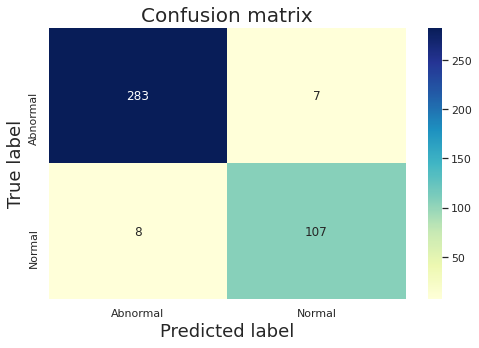

In [11]:
#create CF 
data = {'Actual': act,'Predicted' : pred,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

### ROC curve 

#### -  confusion_matrix function 

In [42]:
def confusion_matrix_all(data_train,threshold):

    #1. manage data  --------------------------------------------------------------------------------------------------------------------------------------------------

    p1 = data_train #Input table   
    act= p1['Class'].map({'Normal':0,'Abnormal':1}).values
    pred = p1['category'].map({'Normal':0,'Abnormal':1}).values

    import numpy as np
    n = len(p1)
    proplist = list()
    for i in range(0,n):
        score = p1.iloc[i].to_numpy()
        if score[10]=='Normal':
            prob = 1 - score[11]
            proplist.append(prob)
        else:
            prob = score[11]
            proplist.append(prob)


    prob_all =np.array(proplist)

#2. เงื่อนไข ---------------------------------------------------------------------------------------------------------------------------------------------
    
    import numpy as np
    from sklearn.metrics import confusion_matrix

    TN, FP, FN, TP = confusion_matrix(act, pred).ravel()
    print(TN, FP, FN, TP)

# 3. threshold ----------------------------------------------------------------


    import numpy as np
    from sklearn.metrics import confusion_matrix

    #threshold = 0
    t = prob_all >= threshold
#     t = np.where(t=='True', 1, t) #repalce True-1,False-0
#     tn, fp, fn, tp = confusion_matrix(act, t).ravel()
#replace
    ts =t.tolist()
    alist =list()
    for i in range(0,len(ts)):
        if ts[i]==  True:
            a = 1
            alist.append(a)
        else:
            a = 0
            alist.append(a)

    tn, fp, fn, tp = confusion_matrix(act, alist).ravel()

    print('(TN,FP,FN,TP)')
    print('(',tn,',', fp,',', fn,',', tp,')')
    return tn, fp, fn, tp


In [36]:
#Test function
threshold = 0.5
confusion_matrix_all(data_train,threshold)

107 8 7 283
(TN,FP,FN,TP)
( 107 , 8 , 7 , 283 )


(107, 8, 7, 283)

#### -  run ROC curve

In [28]:
import numpy as np
threshold = np.arange(0.0, 1.002, 0.001)
precision, recall, ACC, TPR, FPR, SPEC = list(),list(),list(),list(),list(),list()
TN0, FP0, FN0, TP0 = list(),list(),list(),list()
for i in threshold:
    precision0, recall0, ACC0, TPR0, FPR0, SPEC0 = list(),list(),list(),list(),list(),list()
    
    for j in classes:
        tn,fp,fn,tp = confusion_matrix_all(data_train,j,i) 
        try:
            pre = tp/(tp+fp)
            re= tp/(tp+fn)
            acc = (tp+tn)/(tp+tn+fp+fn)
            tpr = tp/(tp+fn)
            fpr = fp/(fp+tn)
            spec = 1-(tn/(tn+fp))
        except ZeroDivisionError:
            pre,re,acc,tpr,fpr,spec =1,0,0,0,0,0      
            
        TP0.append(tp)
        TN0.append(tn)
        FP0.append(fp)
        FN0.append(fn)
        precision0.append(pre)
        recall0.append(re)
        ACC0.append(acc)
        TPR0.append(re)
        FPR0.append(fpr)       
        SPEC0.append(spec)
        
    precision.append(precision0)
    recall.append(recall0)
    ACC.append(ACC0)
    TPR.append(TPR0)
    FPR.append(FPR0)       
    SPEC.append(SPEC0)

107 8 7 283
(TN,FP,FN,TP)
( 0 , 115 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 0 , 115 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 0 , 115 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 0 , 115 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 0 , 115 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 0 , 115 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 0 , 115 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 0 , 115 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 0 , 115 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 0 , 115 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 0 , 115 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 1 , 114 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 1 , 114 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 1 , 114 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 1 , 114 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 1 , 114 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 1 , 114 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 1 , 114 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 1 , 114 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 1 , 114 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 1 , 114 , 0 

107 8 7 283
(TN,FP,FN,TP)
( 56 , 59 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 56 , 59 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 56 , 59 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 57 , 58 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 58 , 57 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 60 , 55 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 60 , 55 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 61 , 54 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 61 , 54 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 61 , 54 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 62 , 53 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 63 , 52 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 63 , 52 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 63 , 52 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 63 , 52 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 63 , 52 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 63 , 52 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 65 , 50 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 66 , 49 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 67 , 48 , 0 , 290 )
107 8 7 283
(TN,FP,FN,TP)
( 67 , 48 , 0 

107 8 7 283
(TN,FP,FN,TP)
( 94 , 21 , 2 , 288 )
107 8 7 283
(TN,FP,FN,TP)
( 94 , 21 , 2 , 288 )
107 8 7 283
(TN,FP,FN,TP)
( 94 , 21 , 2 , 288 )
107 8 7 283
(TN,FP,FN,TP)
( 94 , 21 , 2 , 288 )
107 8 7 283
(TN,FP,FN,TP)
( 94 , 21 , 2 , 288 )
107 8 7 283
(TN,FP,FN,TP)
( 94 , 21 , 2 , 288 )
107 8 7 283
(TN,FP,FN,TP)
( 94 , 21 , 2 , 288 )
107 8 7 283
(TN,FP,FN,TP)
( 94 , 21 , 2 , 288 )
107 8 7 283
(TN,FP,FN,TP)
( 94 , 21 , 2 , 288 )
107 8 7 283
(TN,FP,FN,TP)
( 94 , 21 , 2 , 288 )
107 8 7 283
(TN,FP,FN,TP)
( 94 , 21 , 2 , 288 )
107 8 7 283
(TN,FP,FN,TP)
( 94 , 21 , 3 , 287 )
107 8 7 283
(TN,FP,FN,TP)
( 94 , 21 , 3 , 287 )
107 8 7 283
(TN,FP,FN,TP)
( 94 , 21 , 3 , 287 )
107 8 7 283
(TN,FP,FN,TP)
( 94 , 21 , 3 , 287 )
107 8 7 283
(TN,FP,FN,TP)
( 94 , 21 , 3 , 287 )
107 8 7 283
(TN,FP,FN,TP)
( 94 , 21 , 3 , 287 )
107 8 7 283
(TN,FP,FN,TP)
( 94 , 21 , 3 , 287 )
107 8 7 283
(TN,FP,FN,TP)
( 94 , 21 , 3 , 287 )
107 8 7 283
(TN,FP,FN,TP)
( 94 , 21 , 3 , 287 )
107 8 7 283
(TN,FP,FN,TP)
( 94 , 21 , 3 

107 8 7 283
(TN,FP,FN,TP)
( 108 , 7 , 10 , 280 )
107 8 7 283
(TN,FP,FN,TP)
( 108 , 7 , 10 , 280 )
107 8 7 283
(TN,FP,FN,TP)
( 108 , 7 , 10 , 280 )
107 8 7 283
(TN,FP,FN,TP)
( 108 , 7 , 10 , 280 )
107 8 7 283
(TN,FP,FN,TP)
( 108 , 7 , 10 , 280 )
107 8 7 283
(TN,FP,FN,TP)
( 108 , 7 , 10 , 280 )
107 8 7 283
(TN,FP,FN,TP)
( 109 , 6 , 10 , 280 )
107 8 7 283
(TN,FP,FN,TP)
( 109 , 6 , 10 , 280 )
107 8 7 283
(TN,FP,FN,TP)
( 109 , 6 , 10 , 280 )
107 8 7 283
(TN,FP,FN,TP)
( 109 , 6 , 10 , 280 )
107 8 7 283
(TN,FP,FN,TP)
( 109 , 6 , 10 , 280 )
107 8 7 283
(TN,FP,FN,TP)
( 109 , 6 , 10 , 280 )
107 8 7 283
(TN,FP,FN,TP)
( 109 , 6 , 10 , 280 )
107 8 7 283
(TN,FP,FN,TP)
( 109 , 6 , 10 , 280 )
107 8 7 283
(TN,FP,FN,TP)
( 109 , 6 , 10 , 280 )
107 8 7 283
(TN,FP,FN,TP)
( 109 , 6 , 12 , 278 )
107 8 7 283
(TN,FP,FN,TP)
( 109 , 6 , 12 , 278 )
107 8 7 283
(TN,FP,FN,TP)
( 109 , 6 , 12 , 278 )
107 8 7 283
(TN,FP,FN,TP)
( 109 , 6 , 12 , 278 )
107 8 7 283
(TN,FP,FN,TP)
( 109 , 6 , 12 , 278 )
107 8 7 283
(TN,FP,F

107 8 7 283
(TN,FP,FN,TP)
( 112 , 3 , 49 , 241 )
107 8 7 283
(TN,FP,FN,TP)
( 112 , 3 , 49 , 241 )
107 8 7 283
(TN,FP,FN,TP)
( 112 , 3 , 49 , 241 )
107 8 7 283
(TN,FP,FN,TP)
( 112 , 3 , 49 , 241 )
107 8 7 283
(TN,FP,FN,TP)
( 112 , 3 , 49 , 241 )
107 8 7 283
(TN,FP,FN,TP)
( 112 , 3 , 49 , 241 )
107 8 7 283
(TN,FP,FN,TP)
( 112 , 3 , 49 , 241 )
107 8 7 283
(TN,FP,FN,TP)
( 112 , 3 , 49 , 241 )
107 8 7 283
(TN,FP,FN,TP)
( 112 , 3 , 49 , 241 )
107 8 7 283
(TN,FP,FN,TP)
( 112 , 3 , 49 , 241 )
107 8 7 283
(TN,FP,FN,TP)
( 112 , 3 , 49 , 241 )
107 8 7 283
(TN,FP,FN,TP)
( 112 , 3 , 50 , 240 )
107 8 7 283
(TN,FP,FN,TP)
( 113 , 2 , 50 , 240 )
107 8 7 283
(TN,FP,FN,TP)
( 113 , 2 , 51 , 239 )
107 8 7 283
(TN,FP,FN,TP)
( 113 , 2 , 51 , 239 )
107 8 7 283
(TN,FP,FN,TP)
( 113 , 2 , 52 , 238 )
107 8 7 283
(TN,FP,FN,TP)
( 113 , 2 , 52 , 238 )
107 8 7 283
(TN,FP,FN,TP)
( 113 , 2 , 52 , 238 )
107 8 7 283
(TN,FP,FN,TP)
( 113 , 2 , 52 , 238 )
107 8 7 283
(TN,FP,FN,TP)
( 113 , 2 , 52 , 238 )
107 8 7 283
(TN,FP,F

107 8 7 283
(TN,FP,FN,TP)
( 115 , 0 , 140 , 150 )
107 8 7 283
(TN,FP,FN,TP)
( 115 , 0 , 142 , 148 )
107 8 7 283
(TN,FP,FN,TP)
( 115 , 0 , 142 , 148 )
107 8 7 283
(TN,FP,FN,TP)
( 115 , 0 , 142 , 148 )
107 8 7 283
(TN,FP,FN,TP)
( 115 , 0 , 142 , 148 )
107 8 7 283
(TN,FP,FN,TP)
( 115 , 0 , 144 , 146 )
107 8 7 283
(TN,FP,FN,TP)
( 115 , 0 , 145 , 145 )
107 8 7 283
(TN,FP,FN,TP)
( 115 , 0 , 146 , 144 )
107 8 7 283
(TN,FP,FN,TP)
( 115 , 0 , 146 , 144 )
107 8 7 283
(TN,FP,FN,TP)
( 115 , 0 , 146 , 144 )
107 8 7 283
(TN,FP,FN,TP)
( 115 , 0 , 149 , 141 )
107 8 7 283
(TN,FP,FN,TP)
( 115 , 0 , 150 , 140 )
107 8 7 283
(TN,FP,FN,TP)
( 115 , 0 , 152 , 138 )
107 8 7 283
(TN,FP,FN,TP)
( 115 , 0 , 152 , 138 )
107 8 7 283
(TN,FP,FN,TP)
( 115 , 0 , 152 , 138 )
107 8 7 283
(TN,FP,FN,TP)
( 115 , 0 , 152 , 138 )
107 8 7 283
(TN,FP,FN,TP)
( 115 , 0 , 153 , 137 )
107 8 7 283
(TN,FP,FN,TP)
( 115 , 0 , 155 , 135 )
107 8 7 283
(TN,FP,FN,TP)
( 115 , 0 , 157 , 133 )
107 8 7 283
(TN,FP,FN,TP)
( 115 , 0 , 158 , 132 )


/home/yupaporn/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars


107 8 7 283
(TN,FP,FN,TP)
( 115 , 0 , 290 , 0 )
107 8 7 283
(TN,FP,FN,TP)
( 115 , 0 , 290 , 0 )
107 8 7 283
(TN,FP,FN,TP)
( 115 , 0 , 290 , 0 )
107 8 7 283
(TN,FP,FN,TP)
( 115 , 0 , 290 , 0 )


In [29]:
#average per threshold 
precision1,recall1,ACC1,TPR1,FPR1,SPEC1 = list(),list(),list(),list(),list(),list()
from statistics import *
for m in range(0,len(precision)):
    a1 =mean(precision[m])
    a2 =mean(recall[m])
    a3 =mean(ACC[m])
    a4 =mean(TPR[m])
    a5 =mean(FPR[m])
    a6 =mean(SPEC[m])
    
    precision1.append(a1)
    recall1.append(a2)
    ACC1.append(a3)
    TPR1.append(a4)
    FPR1.append(a5)       
    SPEC1.append(a6)   

In [30]:
#create dataframe
import numpy as np
i = np.arange(len(precision1)) # index for df
roc0 = pd.DataFrame({'Threshold' : pd.Series(threshold, index=i),'Precision' : pd.Series(precision1, index = i),'Recall' : pd.Series(recall1, index = i),
                     'tpr' : pd.Series(TPR1, index = i),'fpr' : pd.Series(FPR1, index = i),'1-Spec' : pd.Series(SPEC1, index = i),  'ACC' : pd.Series(ACC1, index = i), 
                     'TN' : pd.Series(TN0, index = i), 'FP' : pd.Series(FP0, index = i), 'FN' : pd.Series(FN0, index = i), 'TP' : pd.Series(TP0, index = i)},)
roc0 = roc0.fillna(1)

In [31]:
roc0 

,Threshold,Precision,Recall,tpr,fpr,1-Spec,ACC,TN,FP,FN,TP
0,0.000,0.716049,1.0,1.0,1.0,1.0,0.716049,0,115,0,290
1,0.001,0.716049,1.0,1.0,1.0,1.0,0.716049,0,115,0,290
2,0.002,0.716049,1.0,1.0,1.0,1.0,0.716049,0,115,0,290
3,0.003,0.716049,1.0,1.0,1.0,1.0,0.716049,0,115,0,290
4,0.004,0.716049,1.0,1.0,1.0,1.0,0.716049,0,115,0,290
...,...,...,...,...,...,...,...,...,...,...,...
997,0.997,1.000000,0.0,0.0,0.0,0.0,0.283951,115,0,290,0
998,0.998,1.000000,0.0,0.0,0.0,0.0,0.283951,115,0,290,0
999,0.999,1.000000,0.0,0.0,0.0,0.0,0.283951,115,0,290,0
1000,1.000,1.000000,0.0,0.0,0.0,0.0,0.283951,115,0,290,0


#### -  sen VS spec

No handles with labels found to put in legend.


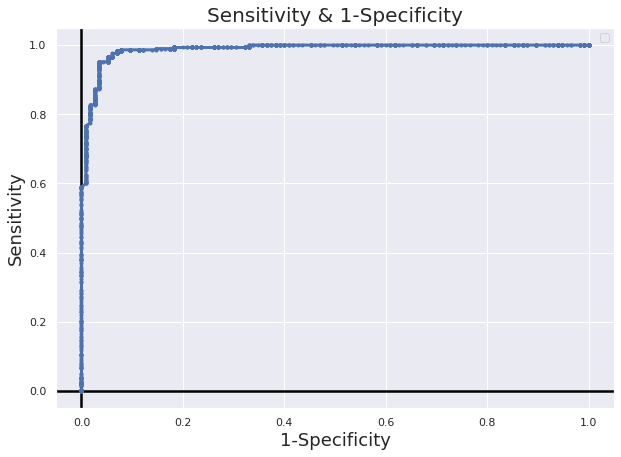

PR AUC (area = 0.99)


In [43]:
#sen VS spec
import numpy as np
import matplotlib.pyplot as plt
sen= np.array(roc0['tpr'])
spec = np.array(roc0['1-Spec'])
# from matplotlib import pyplot
lw = 3
fig, ax = plt.subplots(figsize=(10, 7))
plt.axhline(0, lw=2.5, color='black')
plt.axvline(0, lw=2.5, color='black')
plt.plot([0, 0],[1, 1],'c', linestyle='--',lw=2.5)
plt.plot(spec,sen,'b', marker='.',lw=lw)  
    # axis labels
plt.xlabel('1-Specificity',fontsize=18)
plt.ylabel('Sensitivity',fontsize=18)
plt.title('Sensitivity & 1-Specificity',fontsize=20)
    # show the legend
plt.legend()
    # show the plot
plt.show()
    # calculate the precision-recall auc
from sklearn.metrics import auc
auc_score = auc(spec, sen)
print('PR AUC (area = %0.2f)' % (auc_score))

#### -  Precision & Recall Curve

No handles with labels found to put in legend.


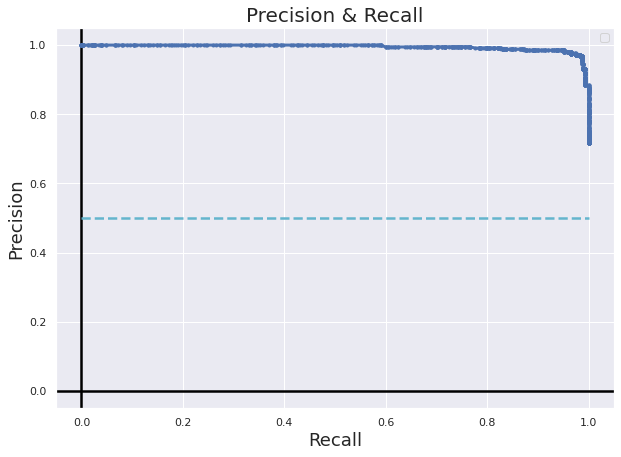

PR AUC (area = 0.99)


In [41]:
#Precision & Recall Curve
import numpy as np
recall = np.array(roc0['Recall'])
precision = np.array(roc0['Precision'])

import matplotlib.pyplot as plt
from matplotlib import pyplot
lw = 3
fig, ax = plt.subplots(figsize=(10, 7))
plt.axhline(0, lw=2.5, color='black')
plt.axvline(0, lw=2.5, color='black')
fig.patch.set_facecolor('w')
plt.plot([0, 1], [0.5, 0.5],'c', linestyle='--',lw=2.5)
pyplot.plot(recall, precision,'b', marker='.', lw=lw)
    # axis labels
pyplot.xlabel('Recall',fontsize=18)
pyplot.ylabel('Precision',fontsize=18)
pyplot.title('Precision & Recall',fontsize=20)
    # show the legend
pyplot.legend()
    # show the plot
pyplot.show()
    # calculate the precision-recall auc
from sklearn.metrics import auc
auc_score = auc(recall, precision)
print('PR AUC (area = %0.2f)' % (auc_score))